# Balancing a Pole on a Cart

This file is suggested to open via Google Colab

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.0
    Uninstalling setuptools-67.6.0:
      Successfully uninstalled setuptools-67.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.02300006  0.02755595 -0.03423402 -0.01958213]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.02244894 -0.16705875 -0.03462566  0.26210603]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 8.0


## Task 1: Development of an RL agent

**Background:**
OpenAI Baselines algorithms DQN with replay buffer and a target network by Deepmind Atari from Google's [Human level control though deep reinforcement learning](http://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf),
The algorithm is as follows:

1. Create a Replay "Buffer" that stores the last #buffer_size S.A.R.S. (State, Action, Reward, New State) experiences.

2. Run your agent, and let it accumulate experiences in the replay-buffer until it (the buffer) has at least #batch_size experiences.

  - You can select actions according to a certain policy (e.g. soft-max for discrete action space, Gaussian for continuous, etc.) over your 𝑄̂ (𝑠,𝑎;𝜃)
 function estimator.
 
3. Once it reaches #batch_size, or more:

  - make a copy of the function estimator (𝑄̂ (𝑠,𝑎;𝜃)
) at the current time, i.e. a copy of the weights 𝜃 - which you "freeze" and don't update, and use to calculate the "true" states 𝑄̂ (𝑠′,𝑎′;𝜃)
. Run for num_replay updates:

    - sample #batch_size experiences from the replay buffer.

    - Use the sampled experiences to preform a batched update to your function estimator (e.g. in Q-Learning where 𝑄̂ (𝑠,𝑎)=
 Neural network - update the weights of the network). Use the frozen weights as the "true" action-values function, but continue to improve the non-frozen function.

  - Do this until you reach a terminal state.

  - Don't forget to constantly append the new experiences to the Replay Buffer

4. Run for as many episodes as you need.

  - $ 𝐿𝑖(𝜃𝑖)=𝔼(𝑠,𝑎,𝑟,𝑠′)∼𝑈(𝐷)[(𝑟+𝛾max𝑎′𝑄(𝑠′,𝑎′;𝜃−𝑖)−𝑄(𝑠,𝑎;𝜃𝑖))^2] $ 

<br/>**Improvement:** Our implementation is based on this algorithm but we re-designed the DQN agent class and tuned the model parameters for better performance.


In [ ]:
import torch
import copy
from collections import deque
from torch import nn
import random
import numpy

class DQN_Agent:
    """
      lr: learning rate
      seed: randomize seed
      sync_freq: frequency of target net sync with main net
      exp_replay_size: experience replay size
    
    """
    def __init__(self, seed, layer_sizes, lr, sync_freq, exp_replay_size):
        torch.manual_seed(seed)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_net = self.build_nn(layer_sizes).to(self.device)
        self.target_net = copy.deepcopy(self.q_net).to(self.device)
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        
        self.network_sync_freq = sync_freq
        self.network_sync_counter = 0
        self.gamma = torch.tensor(0.95).float().to(self.device)
        self.experience_replay = deque(maxlen = exp_replay_size)  
        return
        
    def build_nn(self, layer_sizes):
        assert len(layer_sizes) > 1
        layers = []
        for index in range(len(layer_sizes)-1):
            linear = nn.Linear(layer_sizes[index], layer_sizes[index+1])
            act =    nn.Tanh() if index < len(layer_sizes)-2 else nn.Identity()
            layers += (linear,act)
        return nn.Sequential(*layers)
    
    def get_action(self, state, action_space_len, epsilon):
        # We do not require gradient at this point, because this function will be used either
        # during experience collection or during inference
        with torch.no_grad():
            if(type(state) == tuple):
                state = state[0]
            state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device)
            Qp = self.q_net(state_tensor)
        Q,A = torch.max(Qp, axis=0)
        A = A if torch.rand(1,).item() > epsilon else torch.randint(0,action_space_len,(1,))
        return A
    
    def get_q_next(self, state):
        with torch.no_grad():
            qp = self.target_net(state.to(self.device))
        q,_ = torch.max(qp, axis=1)    
        return q
    
    def collect_experience(self, experience):
        # print(experience)
        self.experience_replay.append(experience)
        return
    
    def sample_from_experience(self, sample_size):
        if(len(self.experience_replay) < sample_size):
            sample_size = len(self.experience_replay)   
        sample = random.sample(self.experience_replay, sample_size)
        s = torch.tensor([exp[0] for exp in sample], dtype=torch.float32, device=self.device)
        a = torch.tensor([exp[1] for exp in sample], dtype=torch.float32, device=self.device)
        rn = torch.tensor([exp[2] for exp in sample], dtype=torch.float32, device=self.device)
        sn = torch.tensor([exp[3] for exp in sample], dtype=torch.float32, device=self.device)
        return s, a, rn, sn
    
    def train(self, batch_size):
        s, a, rn, sn = self.sample_from_experience(sample_size = batch_size)
        if(self.network_sync_counter == self.network_sync_freq):
            self.target_net.load_state_dict(self.q_net.state_dict())
            self.network_sync_counter = 0
        
        # predict expected return of current state using main network
        qp = self.q_net(s.to(self.device))
        pred_return, _ = torch.max(qp, axis=1)
        
        # get target return using target network
        q_next = self.get_q_next(sn.to(self.device))
        target_return = rn.to(self.device) + self.gamma * q_next
        
        loss = self.loss_fn(pred_return, target_return)
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
        
        self.network_sync_counter += 1       
        return loss.item()

For Task 1, we demonstrate the correctness of our implementation of the DQN Agent by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action.

In [ ]:
# set agent parameters
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256

# initialize the DQN Agent
agent = DQN_Agent(seed = 1423, layer_sizes = [input_dim, 64, output_dim], lr = 1e-3, sync_freq = 5, exp_replay_size = exp_replay_size)

In [ ]:
observation = env.reset()
action = agent.get_action(observation, env.action_space.n, epsilon=1).item()
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.04454378  0.00105716 -0.03860185 -0.01157455]
Chosen action: 0


## Training Process of the DQN Agent

Before we proceed to Task 2, we first train the DQN Agent, which involves 3 major tasks.


1.   Initializing experience Replay buffer
2.   Training and updating DQN Agent
3.   Saving model parameters

### 1. Experience Replay <br/>
This part of the code fills the agent's experience replay buffer with initial experiences by executing random actions (epsilon is set to 1) in the environment. Once the buffer reaches the desired size, the loop stops, and the agent can then begin learning from these collected experiences. <br/><br/>
Initializing the experience replay buffer before the training process provides the agent with a diverse set of experiences to learn from, promotes exploration, and improves the stability of the training process.

In [ ]:
#1 Initilize experiance replay 

index = 0

# The 'exp_replay_size' was previously initialized to 256, see Task 1.
for i in range(exp_replay_size):
    obs = env.reset()
    done = False
    while(done != True):
        A = agent.get_action(obs, env.action_space.n, epsilon=1)
        obs_next, reward, done, _= env.step(A.item())
        # Check if the observation obs is a tuple; if so, extract the first element as the observation.
        if type(obs)==tuple:
            obs = obs[0]
        # Call the agent's collect_experience method to store the experience in the form of [obs, action, reward, obs_next].
        agent.collect_experience([obs, A.item(), reward, obs_next])
        obs = obs_next
        index += 1
        if( index > exp_replay_size ):
            break

### 2. Training and updating DQN <br/>
The following code trains a DQN agent using an epsilon-greedy exploration strategy with a decaying epsilon value. The agent collects experiences, updates its policy using mini-batches from the experience replay buffer, and logs various performance metrics for analysis.


In [ ]:
#2 Update DQN parameters

# Import tqdm for displaying a progress bar during the training loop.
from tqdm import tqdm

# Set the parameters
losses_list, reward_list, episode_len_list, epsilon_list  = [], [], [], []
index = 128
episodes = 10000
epsilon = 1

for i in tqdm(range(episodes)):
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while(done != True):
        # This part is similar to the experiance replay
        ep_len += 1 
        A = agent.get_action(obs, env.action_space.n, epsilon)
        obs_next, reward, done, _= env.step(A.item())
        if type(obs)==tuple:
            obs = obs[0]
        agent.collect_experience([obs, A.item(), reward, obs_next])
       
        obs = obs_next
        rew  += reward
        index += 1

        # Check if the index is greater than 128; 
        # if so, reset the index and train the agent with a batch of experiences for 4 iterations.
        if(index > 128):
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=16)
                losses += loss

    # Update the epsilon value using a decay schedule. 
    # Decreasing epsilon by 1/5000 at each episode until it reaches 0.05. 
    if epsilon > 0.05 :
        epsilon -= (1 / 5000)
    
    # Append the average loss, reward, episode length, and epsilon value for the current episode to their respective lists.
    losses_list.append(losses/ep_len), reward_list.append(rew), episode_len_list.append(ep_len), epsilon_list.append(epsilon)

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-10-6f32628d4e4c>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  s = torch.tensor([exp[0] for exp in sample], dtype=torch.float32, device=self.device)
100%|██████████| 10000/10000 [07:18<00:00, 22.82it/s]


### 3. Save model parameters <br/>
We save the models parameters to a .pth file for later loading

In [ ]:
#3 Save model parameters
torch.save(agent.q_net.state_dict(), 'dqn_agent_params.pth')

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, we use the trained DQN agent to play the game for 100 episodes, record the cumulative reward for each round, and plot the reward for each round.

In [ ]:
# set the environment
env = gym.make('CartPole-v1')

In [ ]:
# set the agent parameters
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256

# initialize the DQN Agent as before
agent = DQN_Agent(seed = 1423, layer_sizes = [input_dim, 64, output_dim], lr = 1e-3, sync_freq = 5, exp_replay_size = exp_replay_size)

# load the model parameters from the trained agent
agent.q_net.load_state_dict(torch.load('dqn_agent_params.pth'))

<All keys matched successfully>

episode : 0, reward : 500.0
episode : 1, reward : 500.0
episode : 2, reward : 500.0
episode : 3, reward : 500.0
episode : 4, reward : 500.0
episode : 5, reward : 500.0
episode : 6, reward : 500.0
episode : 7, reward : 500.0
episode : 8, reward : 500.0
episode : 9, reward : 500.0
episode : 10, reward : 500.0
episode : 11, reward : 500.0
episode : 12, reward : 500.0
episode : 13, reward : 500.0
episode : 14, reward : 500.0
episode : 15, reward : 500.0
episode : 16, reward : 500.0
episode : 17, reward : 500.0
episode : 18, reward : 500.0
episode : 19, reward : 500.0
episode : 20, reward : 500.0
episode : 21, reward : 500.0
episode : 22, reward : 500.0
episode : 23, reward : 500.0
episode : 24, reward : 500.0
episode : 25, reward : 500.0
episode : 26, reward : 500.0
episode : 27, reward : 500.0
episode : 28, reward : 500.0
episode : 29, reward : 500.0
episode : 30, reward : 500.0
episode : 31, reward : 500.0
episode : 32, reward : 500.0
episode : 33, reward : 500.0
episode : 34, reward : 5

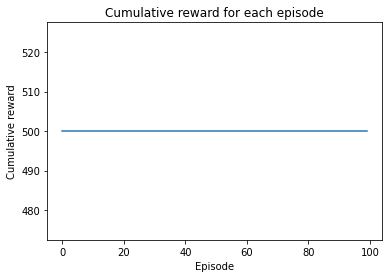

In [ ]:
# initialize the cumulative reward list
episode_rewards = []

# play 100 episodes and record the reward for each episode 
for i in range(100):
    obs, done, rew = env.reset(), False, 0
    while (done != True) :
        A =  agent.get_action(obs, env.action_space.n, epsilon = 0)
        obs, reward, done, info = env.step(A.item())
        rew += reward
    episode_rewards.append(rew) 
    print("episode : {}, reward : {}".format(i,rew))

plt.plot(episode_rewards)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

In [ ]:
print("Average cumulative reward:", numpy.mean(episode_rewards))
print("Is my agent good enough?", numpy.mean(episode_rewards) > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

We plug our agent to the code below to obtain the rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    # our agent goes here
    action = agent.get_action(observation, env.action_space.n, epsilon = 0).item()
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()